In [6]:
import os
import json
import folium
import pandas as pd
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
rfile  = '시군구.geojson'
geo_str= json.load(open(rfile,encoding='utf-8'))
train_df = pd.read_csv('train1.csv')
test_df  = pd.read_csv('test1.csv')
train_df = train_df.groupby('발생지_시군구').mean().sort_values(by='Risk', ascending=False)
test_df  = test_df.groupby('발생지_시군구').mean().sort_values(by='Risk', ascending=False)

#### 표준화 작업
- Risk, 응급실_개수, 시군구별_인구의 값은 모두 0이상의 값을 가지고  있으므로 0 ~ 1사이의 값으로 일괄적으로 표준화해주기 위해 Min-Max 이용.
- Train(실제), Test(예측) 각 데이터에 대하여 실시.

In [3]:
scaler  = MinMaxScaler()
scaled_train  = scaler.fit_transform(train_df)
df_scaled_train = pd.DataFrame(scaled_train)
df_scaled_train.columns = ['Risk', '응급실_개수', '시군구별_인구']
df_scaled_train.index = train_df.index
df_scaled_train

,Risk,응급실_개수,시군구별_인구
발생지_시군구,,,
무주군,1.000000,0.000000,0.020482
영광군,0.820513,0.111111,0.045231
통영시,0.758974,0.000000,0.111431
장수군,0.738462,0.000000,0.019083
장흥군,0.707692,0.055556,0.032797
...,...,...,...
연수구,0.029150,0.055556,0.291266
해운대구,0.000000,0.111111,0.341134
성북구,0.000000,0.055556,0.367559


#### Risk, 응급실수, 인구수를 고려한 시각화

In [4]:
scaler  = MinMaxScaler()
scaled_test = scaler.fit_transform(test_df)
df_scaled_test = pd.DataFrame(scaled_test)
df_scaled_test.columns = ['Risk', '응급실_개수', '시군구별_인구']
df_scaled_test.index = test_df.index
df_scaled_test

,Risk,응급실_개수,시군구별_인구
발생지_시군구,,,
삼척시,1.000000,0.055556,0.056713
부여군,0.872868,0.000000,0.056667
단양군,0.811276,0.000000,0.025075
영주시,0.745144,0.055556,0.088998
남원시,0.665475,0.055556,0.068721
...,...,...,...
해운대구,0.039216,0.111111,0.341134
사상구,0.019866,0.111111,0.186388
영덕군,0.010361,0.000000,0.031681


In [ ]:
m_true = folium.Map(location=[36.8, 127.5], tiles= 'Stamen Toner',zoom_start = 7, width = 850)
m_true.choropleth(
            geo_data     = geo_str, 
            data         = train_df,
            columns      = [test_df.index, '응급실_개수','Risk'],
            key_on       ='properties.SIG_KOR_NM',
            fill_color   = 'YlGnBu',
            fill_opacity = 0.7,
            line_opacity = 0.3,
            colors=['red','blue']
            )
# m_true.save('MAP_TRUE.html')
# m_true

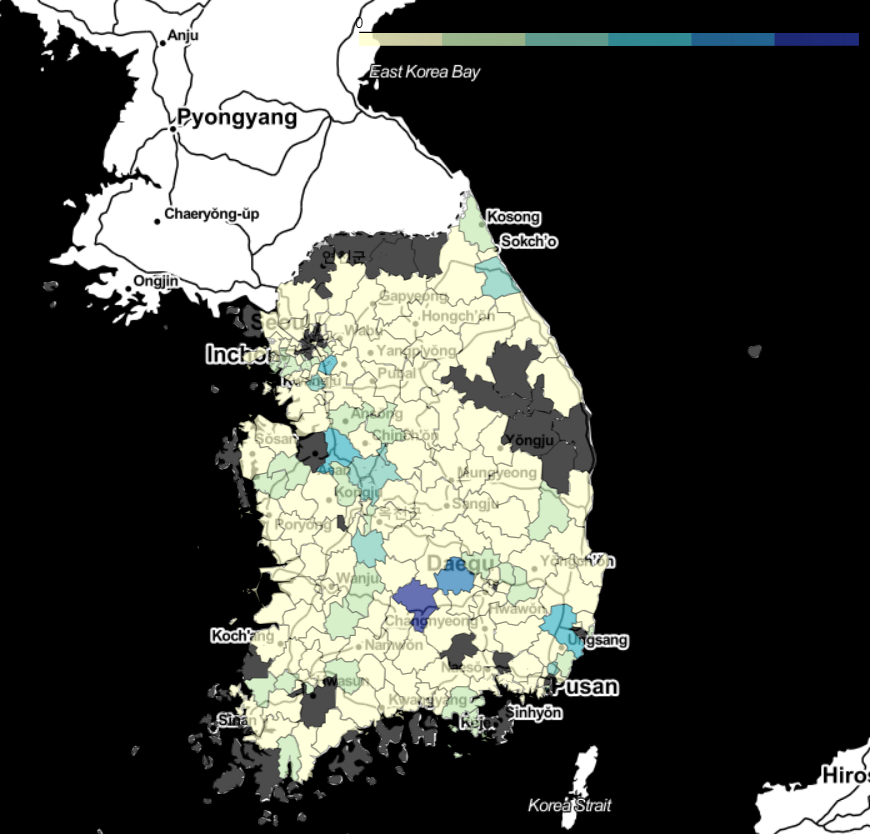

In [11]:
Image('과정/1.png')

In [ ]:
m_pred = folium.Map(location=[36.8, 127.5], tiles= 'Stamen Toner',zoom_start = 7, width = 850)
m_pred.choropleth(
            geo_data     = geo_str, 
            data         = test_df,
            columns      = [test_df.index, '응급실 개수','Risk'],
            key_on       ='properties.SIG_KOR_NM',
            fill_color   = 'YlGnBu',
            fill_opacity = 0.7,
            line_opacity = 0.3,
            colors=['red','blue']
            )
# m_pred.save('MAP_PRED.html')
# m_pred

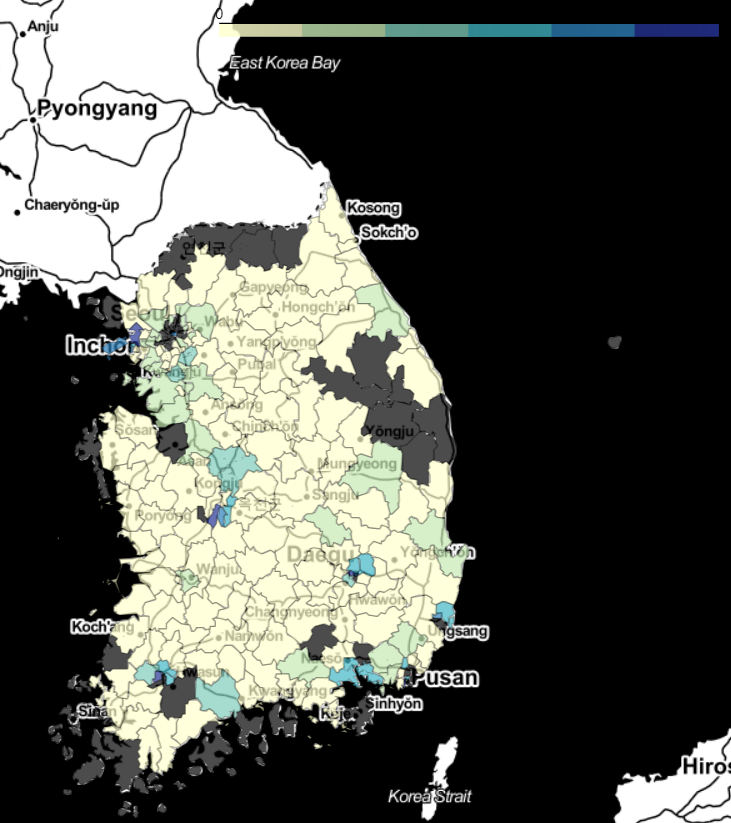

In [10]:
Image('과정/2.png')

In [ ]:
print(f" 전체 시군구 수 : {len(geo_str['features'])}개")

#### Risk, 응급실수, 인구수를 고려한 서클 시각화 (Train Data = 실제값)

In [ ]:
def center_calc(points_df) :
    x = points_df.x
    y = points_df.y
    X = (max(x) + min(x)) / 2.
    Y = (max(y) + min(y)) / 2.
    return X, Y


def points_array(points) :
    final_points = []
    for x in range(0, len(points)) :
        if len(points[x]) == 2 :
            final_points.append(points[x])
        else :
            target = points[x]
            for y in range(0, len(target)) :
                final_points.append(target[y])
    return final_points

center_locations = pd.DataFrame()
codes  = []
names  = []
x_list = []
y_list = []

for x in range(0, len(geo_str['features'])):
    code = geo_str['features'][x]['properties']['SIG_CD']
    name = geo_str['features'][x]['properties']['SIG_KOR_NM']

    points = geo_str['features'][x]['geometry']['coordinates'][0]
    points = points_array(points)
    points_df = pd.DataFrame(points)
    points_df.columns = ['x','y']
    X, Y = center_calc(points_df)
    
    codes.append(code)
    names.append(name)
    x_list.append(X)
    y_list.append(Y)
    
# print(len(codes), len(names), len(x_list),len(y_list))


center_locations['CODE'] = codes
center_locations['NAME'] = names
center_locations['X']    = x_list
center_locations['Y']    = y_list

df = df_scaled_train
inter = set(df.index) & set(center_locations['NAME'])
code_dic = { name : code for name, code in zip(center_locations['NAME'], center_locations['CODE']) if name in inter }
df['CODE'] = [code_dic.get(i) for i in df.index] 
    
center_locations['X'] = center_locations['X'].astype('str')
center_locations['Y'] = center_locations['Y'].astype('str')
center_locations['XY'] = center_locations['X'] + ',' + center_locations['Y']
lat_lon = {code : xy for code, xy in zip(center_locations['CODE'], center_locations['XY'])}

df_lat_lon = [lat_lon.get(i) for i in df['CODE']]

l1, l2 = [], []
for i in df_lat_lon :
    li = i.split(',')
    lat = li[0] 
    lon = li[-1]
    l1.append(lat)
    l2.append(lon)
    
df['lat'] = l1
df['lon'] = l2

m = folium.Map(location = [36.8, 127.5], tiles = 'Stamen Toner', zoom_start = 7, width = 1000)

m.choropleth(
            geo_data     = geo_str, 
            data         = df,
            columns      = [test_df.index, '응급실_개수','Risk', '시군구별_인구'],
            key_on       ='properties.SIG_KOR_NM',
            fill_color   = 'PuRd',
            fill_opacity = 0.7,
            line_opacity = 0.3,
            colors=['red','blue']
            )

for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['Risk'][idx] * 20,
                        popup = df.index[idx],
                        fill_color='#3186cc',
                        color='blue').add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# -------------------------------------------------------------------------------------------------
for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['응급실_개수'][idx] * 20,  
                        popup = df.index[idx],
                        color='red').add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# -------------------------------------------------------------------------------------------------
for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['시군구별_인구'][idx] * 20,  
                        popup = df.index[idx],
                        color='yellow').add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m.save('MAP_RISK.html')
m

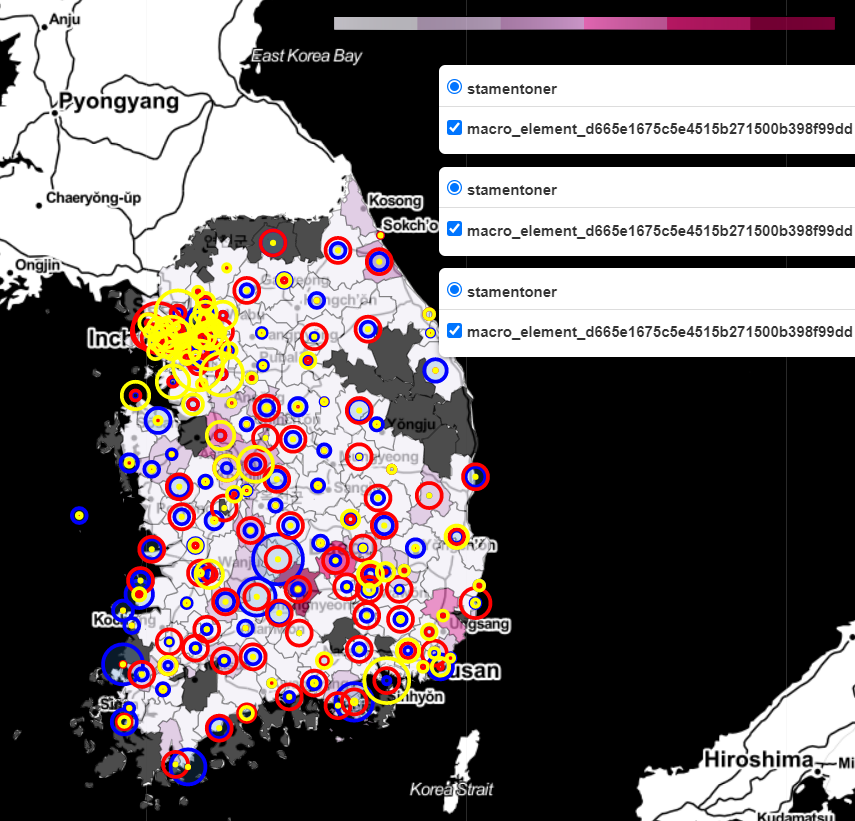

In [12]:
Image('과정/3.png')

#### Risk + 응급실 수 + 인구수의 총합을 고려한 순위 생성 및 시각화(Train Data = 실제값)

In [ ]:
rank = -(-df_scaled_train.iloc[:, :1].values + df_scaled_train.iloc[:, 1:2].values + df_scaled_train.iloc[:, 2:3].values)
df['rank_risk'] = rank
df_top_10 = df.sort_values("rank_risk", ascending = False)[:10]

rank_m = folium.Map(location = [36.8, 127.5], tiles = 'Stamen Toner', zoom_start = 7, width = 1000)

df = df_top_10
rank_m.choropleth(
                geo_data     = geo_str, 
                data         = df,
                columns      = [df.index, 'rank_risk'],
                key_on       ='properties.SIG_KOR_NM',
                fill_color   = 'PuRd',
                fill_opacity = 0.7,
                line_opacity = 0.3,
                colors=['red']
                )

for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['rank_risk'][idx] * 30,
                        popup = df.index[idx],
                        color ='red').add_to(rank_m)

folium.LayerControl(collapsed=False).add_to(rank_m)

rank_m.save('MAP_RANK.html')
rank_m

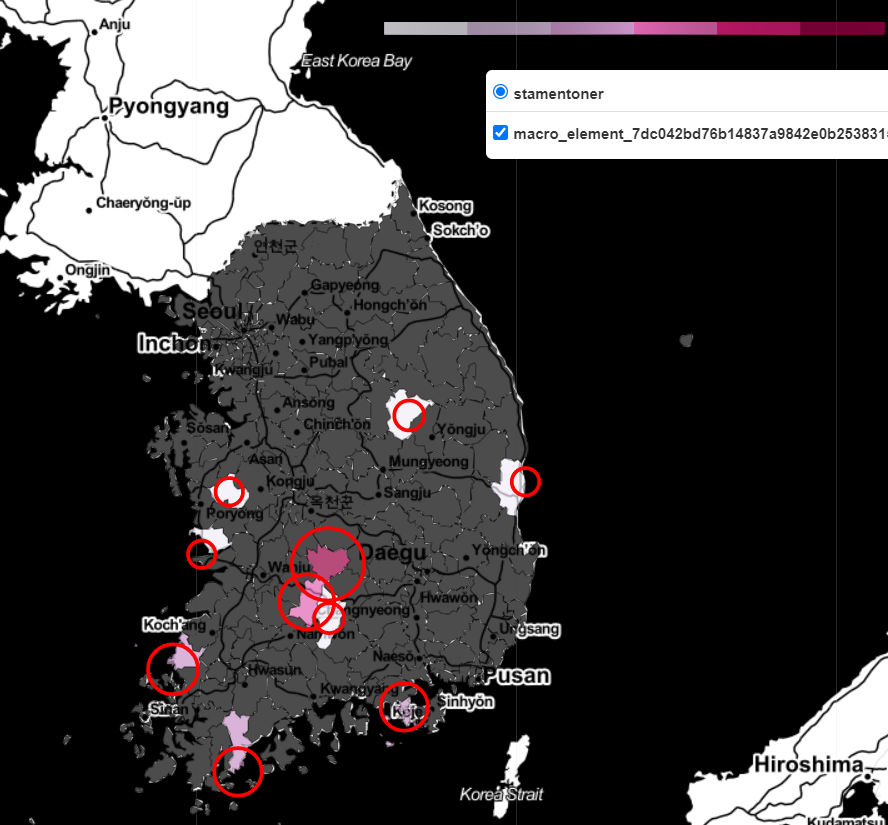

In [13]:
Image('과정/5.png')

#### QGIS를 이용하기 위한 상위 10개 위험도 분석 지역 데이터 저장(실제)

In [ ]:
df_top_10.to_csv('true.csv', encoding = 'euc-kr')
df_top_10

---

#### Risk + 응급실 수 + 인구수의 총합을 고려한 순위 생성 및 시각화(Test Data = 예측값)

In [ ]:
def center_calc(points_df) :
    x = points_df.x
    y = points_df.y
    X = (max(x) + min(x)) / 2.
    Y = (max(y) + min(y)) / 2.
    return X, Y


def points_array(points) :
    final_points = []
    for x in range(0, len(points)) :
        if len(points[x]) == 2 :
            final_points.append(points[x])
        else :
            target = points[x]
            for y in range(0, len(target)) :
                final_points.append(target[y])
    return final_points

center_locations = pd.DataFrame()
codes  = []
names  = []
x_list = []
y_list = []

for x in range(0, len(geo_str['features'])):
    code = geo_str['features'][x]['properties']['SIG_CD']
    name = geo_str['features'][x]['properties']['SIG_KOR_NM']

    points = geo_str['features'][x]['geometry']['coordinates'][0]
    points = points_array(points)
    points_df = pd.DataFrame(points)
    points_df.columns = ['x','y']
    X, Y = center_calc(points_df)
    
    codes.append(code)
    names.append(name)
    x_list.append(X)
    y_list.append(Y)
    
# print(len(codes), len(names), len(x_list),len(y_list))


center_locations['CODE'] = codes
center_locations['NAME'] = names
center_locations['X']    = x_list
center_locations['Y']    = y_list

df = df_scaled_test
inter = set(df.index) & set(center_locations['NAME'])
code_dic = { name : code for name, code in zip(center_locations['NAME'], center_locations['CODE']) if name in inter }
df['CODE'] = [code_dic.get(i) for i in df.index] 
    
center_locations['X'] = center_locations['X'].astype('str')
center_locations['Y'] = center_locations['Y'].astype('str')
center_locations['XY'] = center_locations['X'] + ',' + center_locations['Y']
lat_lon = {code : xy for code, xy in zip(center_locations['CODE'], center_locations['XY'])}

df_lat_lon = [lat_lon.get(i) for i in df['CODE']]

l1, l2 = [], []
for i in df_lat_lon :
    li = i.split(',')
    lat = li[0] 
    lon = li[-1]
    l1.append(lat)
    l2.append(lon)
    
df['lat'] = l1
df['lon'] = l2

m = folium.Map(location = [36.8, 127.5], tiles = 'Stamen Toner', zoom_start = 7, width = 1000)

m.choropleth(
            geo_data     = geo_str, 
            data         = df,
            columns      = [test_df.index, '응급실_개수','Risk', '시군구별_인구'],
            key_on       ='properties.SIG_KOR_NM',
            fill_color   = 'PuRd',
            fill_opacity = 0.7,
            line_opacity = 0.3,
            colors=['red','blue']
            )

for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['Risk'][idx] * 20,
                        popup = df.index[idx],
                        fill_color='#3186cc',
                        color='blue').add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# -------------------------------------------------------------------------------------------------
for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['응급실_개수'][idx] * 20,  
                        popup = df.index[idx],
                        color='red').add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# -------------------------------------------------------------------------------------------------
for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['시군구별_인구'][idx] * 20,  
                        popup = df.index[idx],
                        color='yellow').add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m

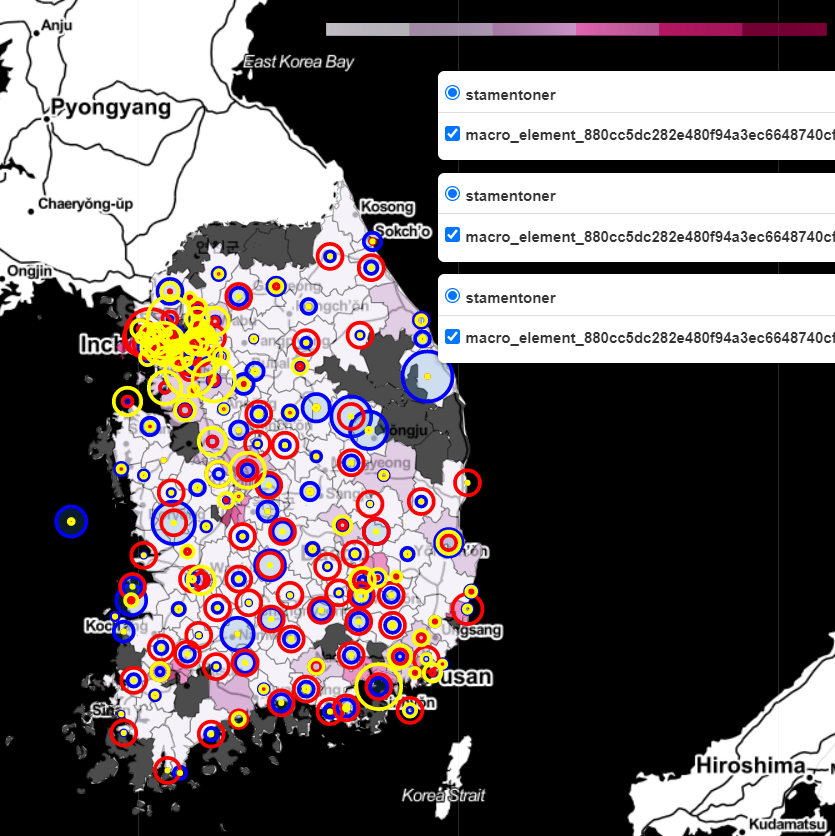

In [14]:
Image('과정/4.png')

#### Risk, 응급실수, 인구수를 고려한 서클 시각화 (Test Data = 예측값)

In [ ]:
rank = -(-df_scaled_test.iloc[:, :1].values + df_scaled_test.iloc[:, 1:2].values + df_scaled_test.iloc[:, 2:3].values)
df['rank_risk'] = rank
df_top_10 = df.sort_values("rank_risk", ascending = False)[:10]

rank_m = folium.Map(location = [36.8, 127.5], tiles = 'Stamen Toner', zoom_start = 7, width = 1000)

df = df_top_10
rank_m.choropleth(
                geo_data     = geo_str, 
                data         = df,
                columns      = [df.index, 'rank_risk'],
                key_on       ='properties.SIG_KOR_NM',
                fill_color   = 'PuRd',
                fill_opacity = 0.7,
                line_opacity = 0.3,
                colors=['red']
                )

for idx in range(0, len(df)) :
    latitude  = df['lon'][idx]
    longitude = df['lat'][idx]
    location  = (latitude, longitude)
    folium.CircleMarker(location, radius = df['rank_risk'][idx] * 30,
                        popup = df.index[idx],
                        color ='red').add_to(rank_m)

folium.LayerControl(collapsed=False).add_to(rank_m)
rank_m

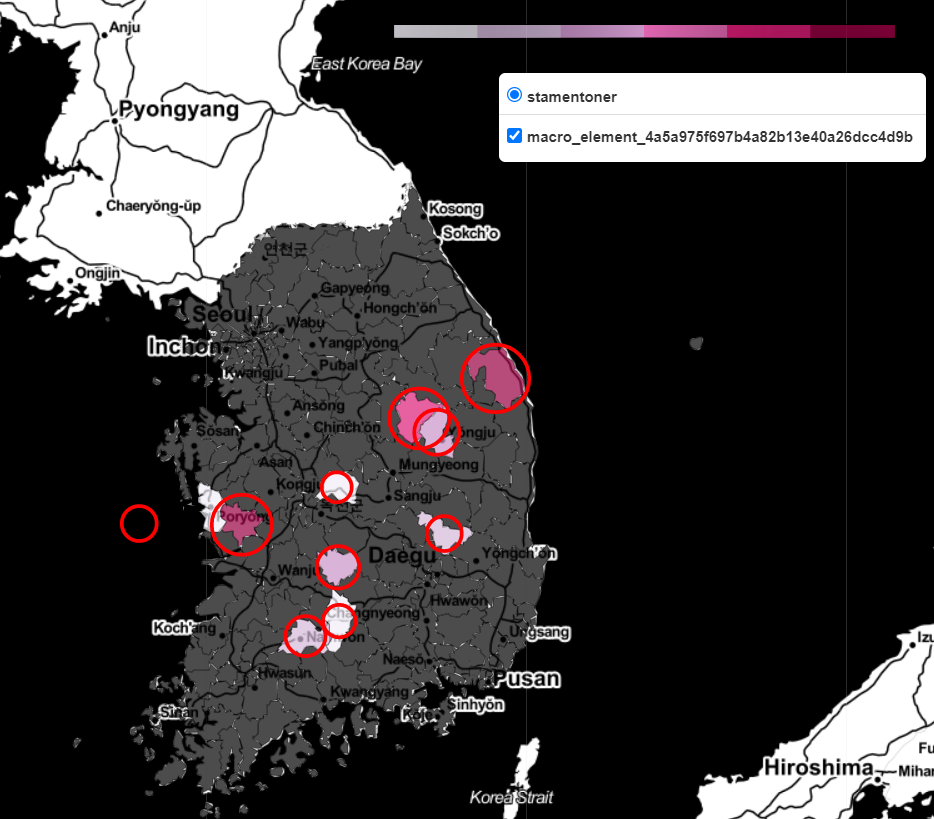

In [15]:
Image('과정/6.png')

#### QGIS를 이용하기 위한 상위 10개 위험도 분석 지역 데이터 저장(예측)

In [ ]:
df_top_10.to_csv('pred.csv', encoding = 'euc-kr')
df_top_10

#### 참고
- Heatmap

In [ ]:
m         = folium.Map(location = [36.8, 127.5], tiles = 'Stamen Toner', zoom_start = 7, width = 850)
heat_df   = df[['lat', 'lon']]
heat_data = [[row['lon'],row['lat']] for index, row in heat_df.iterrows()]
HeatMap(heat_data).add_to(m)
m

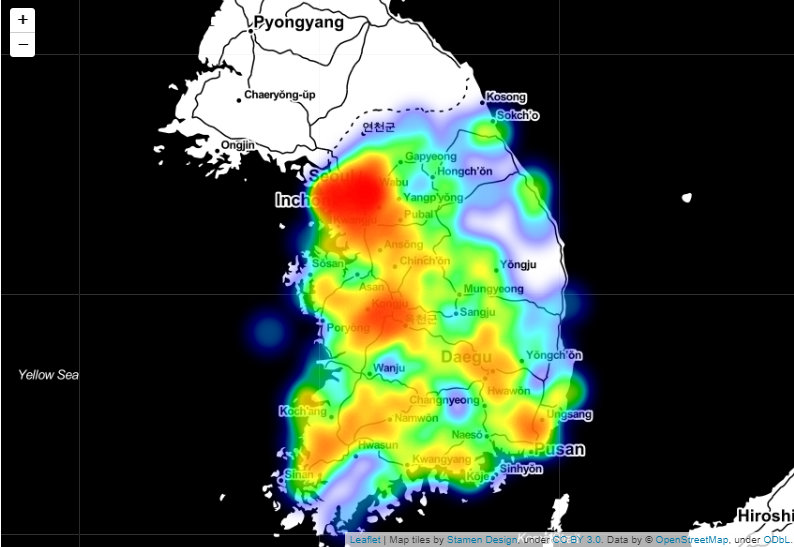

In [16]:
Image('과정/7.png')